# **Import Data**

In [294]:
import pandas as pd

# Import data
legit = pd.read_csv("datasets/unb-university/Benign_list_big_final.csv")
phishing = pd.read_csv("datasets/unb-university/phishing_dataset.csv")
malware = pd.read_csv("datasets/unb-university/Malware_dataset.csv")
spam = pd.read_csv("datasets/unb-university/spam_dataset.csv")

In [295]:
legit.columns = ['url']
phishing.columns = ['url']
malware.columns = ['url']
spam.columns = ['url']

malicious = pd.concat([phishing, malware, spam])

# **Prepare Data**

In [296]:
# Check null values
print(f"Legit null values: {legit.isnull().sum()}")
print()
print(f"Malicious null values: {malicious.isnull().sum()}")

Legit null values: url    0
dtype: int64

Malicious null values: url    0
dtype: int64


In [297]:
# Drop duplicates
print(f"Legit's duplicates num: {legit.duplicated().sum()}")
print(f"Malicious duplicates num: {malicious.duplicated().sum()}")

legit = legit.drop_duplicates()
malicious = malicious.drop_duplicates()
print()
print("After dropping duplicates")

print(f"Legit's duplicates num: {legit.duplicated().sum()}")
print(f"Malicious duplicates num: {malicious.duplicated().sum()}")

Legit's duplicates num: 0
Malicious duplicates num: 8962

After dropping duplicates
Legit's duplicates num: 0
Malicious duplicates num: 0


In [298]:
# Check if there is imbalance
print(legit.shape)
print(malicious.shape)

(35377, 1)
(24566, 1)


In [299]:
# Add the right amount of phishing urls data from phishtank
phishtank = pd.read_csv('datasets/phishtank-phishing-urls.csv')

# Get the missing amount
legit_mal_diff = int(len(legit.index) - len(malicious.index))

# Randomly select the urls from phishtank dataset
phishtank = phishtank.sample(n=legit_mal_diff,random_state=42)
phishtank.shape

(10811, 1)

In [300]:
malicious_added = pd.concat([malicious, phishtank])

print(legit.shape)
print(malicious_added.shape)

(35377, 1)
(35377, 1)


In [301]:
# add a 'label' column to the dataframes
legit["label"] = 0
malicious_added["label"] = 1

In [302]:
# combine the two dataframes
df = pd.concat([legit, malicious_added], ignore_index=True)

# shuffle the dataframe's rows randomly
df = df.sample(frac=1, random_state=42) # Set random_state to an integer for reproducibility
df.reset_index(drop=True, inplace=True)

print(df.shape)

(70754, 2)


<Axes: xlabel='label', ylabel='count'>

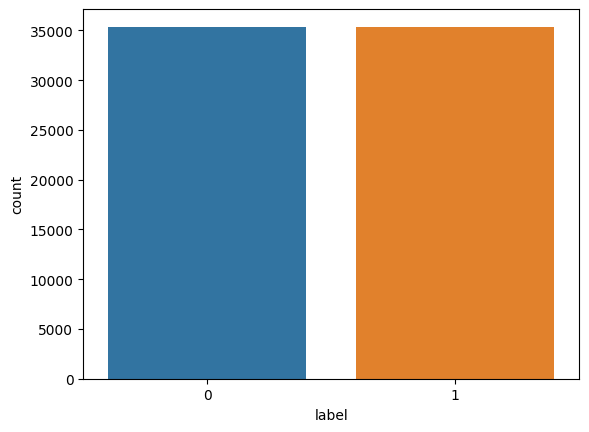

In [303]:
import seaborn as sns

# print the counts for each category
sns.countplot(x=df["label"])

In [304]:
print(df.isnull().sum())
print(df.duplicated().sum())

url      0
label    0
dtype: int64
1


# **Extracting Features**

In [305]:
# importing required packages for this section
from urllib.parse import urlparse
import ipaddress
import re

# 1.Domain of the URL (Domain) 
def getDomain(url):  
    domain = urlparse(url).netloc
    if re.match(r"^www.",domain):
            domain = domain.replace("www.","")
    return domain

# 2.Checks for IP address in URL (Have_IP)
def havingIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip

# 3.Checks the presence of @ in URL (Have_At)
def haveAtSign(url):
    if "@" in url:
        at = 1
    else:
        at = 0    
    return at

# 4.Finding the length of URL and categorizing (URL_Length)
def getLength(url):
    if len(url) < 54:
        return 1
    else:
        return 0

# 5.Gives number of '/' in URL (URL_Depth)
def getDepth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth

# 6.Checking for redirection '//' in the url (Redirection)
def redirection(url):
    pos = url.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

# 7.Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def httpDomain(url):
    domain = urlparse(url).netloc
    if 'https' in domain:
        return 1
    else:
        return 0
    

# Combine them in to one function
def featureExtraction(url,label):
    
    features = []
    features.append(url)
    #Address bar based features (10)
    features.append(getDomain(url))
    features.append(havingIP(url))
    features.append(haveAtSign(url))
    features.append(getLength(url))
    features.append(getDepth(url))
    features.append(redirection(url))
    features.append(httpDomain(url))
    features.append(label)

    return features

In [306]:
features = []

for i in range(len(df)):
    url = df['url'][i]
    label = df['label'][i]
    features.append(featureExtraction(url,label))

In [307]:
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)
df.head(2)

,url,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,label
0,http://mylust.com/videos/235749/japanese-anime...,mylust.com,0,0,0,3,0,0,0
1,http://troikacapital.ru/glavnoe_upravlenie_min...,troikacapital.ru,0,0,0,1,0,0,1


# **EDA**

<Axes: xlabel='https_Domain', ylabel='count'>

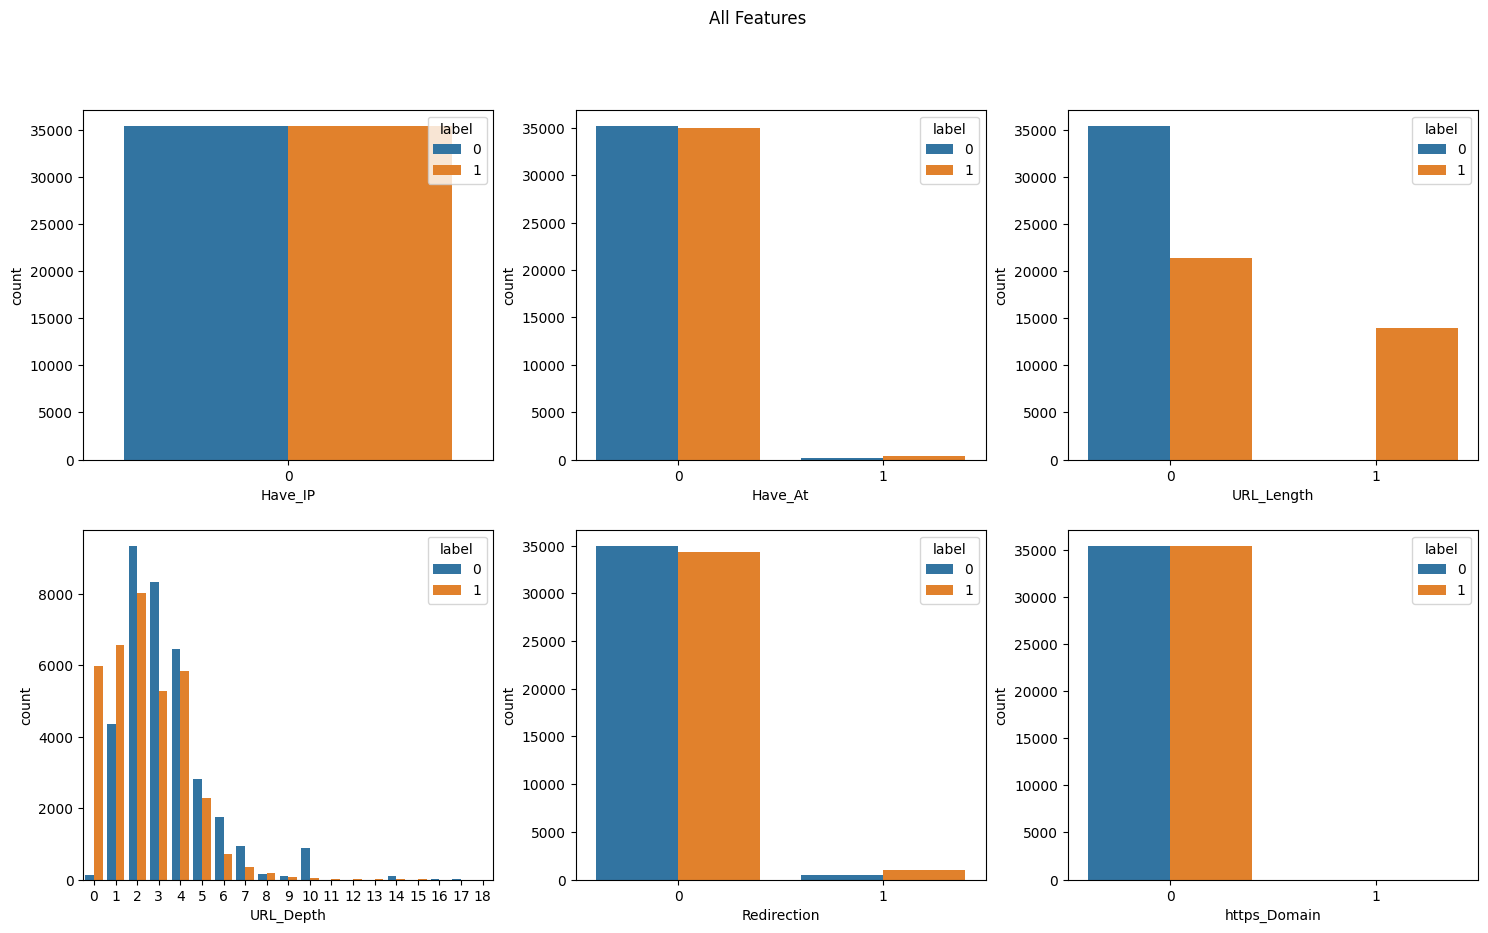

In [308]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('All Features')

iris = sns.load_dataset("iris")

sns.countplot(ax=axes[0, 0], data=df, x="Have_IP", hue="label")
sns.countplot(ax=axes[0, 1], data=df, x="Have_At", hue="label")
sns.countplot(ax=axes[0, 2], data=df, x="URL_Length", hue="label")
sns.countplot(ax=axes[1, 0], data=df, x="URL_Depth", hue="label")
sns.countplot(ax=axes[1, 1], data=df, x="Redirection", hue="label")
sns.countplot(ax=axes[1, 2], data=df, x="https_Domain", hue="label")

In [309]:
# Features can be used: URL_Length, URL_Depth

# **Vectorizing and Labeling**

In [310]:
url_df = df['url']
domain_df = df['Domain']
feature_df = df[['URL_Length', 'URL_Depth']]
label_df = df['label']

In [311]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import numpy as np

# Vectorize URLs
vectorizer_url = CountVectorizer()
url_vec = vectorizer_url.fit_transform(url_df)

# Vectorize Domains
vectorizer_domain = CountVectorizer()
domain_vec = vectorizer_domain.fit_transform(domain_df)

# Convert other features to arrays
features_arr = np.asarray(feature_df)
scaler = StandardScaler()
features_arr_scaled = scaler.fit_transform(features_arr)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr_scaled)), format='csr')

# Label to array
label_arr = np.asarray(label_df)

# **Train Test Split**

In [312]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(combined_features_arr, label_arr, test_size=0.25, random_state=42)

print('Train: ', x_train.shape[0])
print('Test: ', x_test.shape[0])

Train:  53065
Test:  17689


# **Logistic Regression**

In [313]:
# modeling lbfgs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C= 0.01, class_weight= 'balanced', max_iter= 500, penalty= 'l2', random_state=42)
lr_lbfgs = logreg.fit(x_train,y_train)

In [314]:
y_pred_lr=logreg.predict(x_test)
print(y_pred_lr)

[0 0 1 ... 1 1 0]


In [315]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.2f}")

# Calculate f1 score
f1 = f1_score(y_test, y_pred_lr)
print(f"F1 score: {f1:.2f}")

# Calculate jaccard score
print(f"Jaccard score: {jaccard_score(y_test, y_pred_lr,pos_label=0)}")


Accuracy: 0.97
F1 score: 0.97
Jaccard score: 0.9461639058413251


Text(0.5, 427.9555555555555, 'Predicted label')

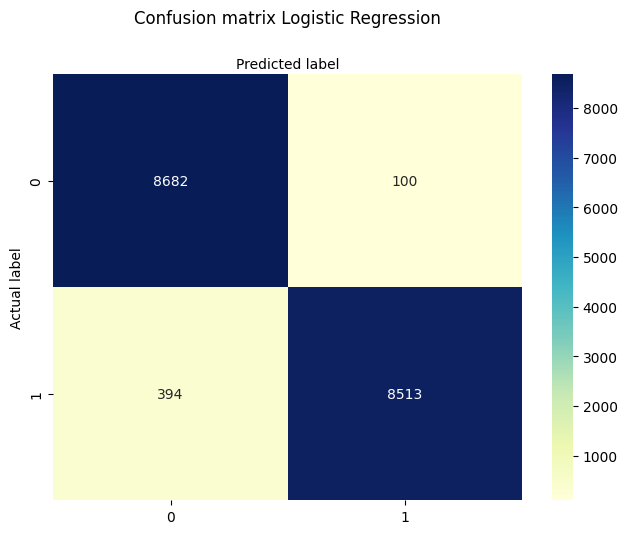

In [316]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_lr)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# **Bernoulli Naive Bayes**

In [317]:
from sklearn.naive_bayes import BernoulliNB

# Create an instance of the BernoulliNB classifier
bnb = BernoulliNB()
bnb.fit(x_train, y_train)

BernoulliNB()

In [318]:
y_pred_bnb=bnb.predict(x_test)

from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_bnb)
print(f"Accuracy: {accuracy:.2f}")

# Calculate f1 score
f1 = f1_score(y_test, y_pred_bnb)
print(f"F1 score: {f1:.2f}")

# Calculate jaccard score
print(f"Jaccard score: {jaccard_score(y_test, y_pred_bnb,pos_label=0)}")

Accuracy: 0.99
F1 score: 0.99
Jaccard score: 0.9762783931968222


Text(0.5, 427.9555555555555, 'Predicted label')

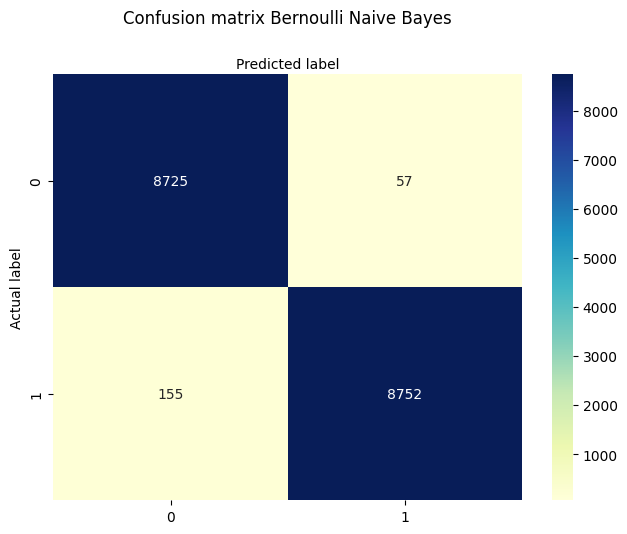

In [319]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_bnb)

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Bernoulli Naive Bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# **Testing**

In [320]:
test_df = pd.read_csv('datasets/publish-test.csv')
test_df.head(3)

,x,y,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1,NaN,NaN,NaN
1,http://ca.linkedin.com/directory/people/ca/pou...,0,NaN,NaN,NaN
2,http://www.ccent.com.au/index.php?option=com_m...,1,NaN,NaN,NaN


In [321]:
test = test_df[['x','y']]

test.isnull().sum()
test.dropna()
indexValue = test[test['y'] == 'continue=to&amp'].index
test.drop(indexValue , inplace=True)
test.reset_index(drop=True, inplace=True)

test.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_21268\3745391195.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(indexValue , inplace=True)


(99, 2)

In [322]:
x_t = test['x']
y_t = test['y'].astype(int)

features = []

for i in range(len(test)):
    url = x_t[i]
    label = y_t[i]
    features.append(featureExtraction(url,label))

#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']
df = pd.DataFrame(features, columns= feature_names)

url_df = df['url']
domain_df = df['Domain']
feature_df = df[['URL_Length', 'URL_Depth']]
label_df = df['label']

In [323]:
# Vectorize URLs
url_vec = vectorizer_url.transform(url_df)

# Vectorize Domains
domain_vec = vectorizer_domain.transform(domain_df)

features_arr = np.asarray(feature_df)
features_arr_scaled = scaler.transform(features_arr)

combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr_scaled)), format='csr')

y_t = np.asarray(label_df)

## Logistic Regression

In [324]:
y_t_pred_lr = logreg.predict(combined_features_arr)

print(f"Jaccard score: {jaccard_score(y_t, y_t_pred_lr,pos_label=0)}")

accuracy = accuracy_score(y_t, y_t_pred_lr)
print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(y_t, y_t_pred_lr)
print(f"F1 score: {f1:.2f}")

Jaccard score: 0.34
Accuracy: 0.67
F1 score: 0.75


Text(0.5, 427.9555555555555, 'Predicted label')

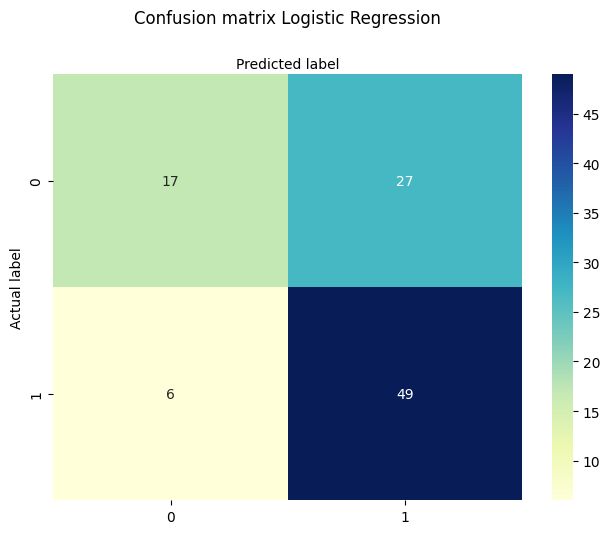

In [325]:
cnf_matrix = metrics.confusion_matrix(y_t, y_t_pred_lr)
cnf_matrix

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Bernoulli Naive Bayes

In [326]:
y_t_pred_bnb = bnb.predict(combined_features_arr)

print(f"Jaccard score: {jaccard_score(y_t, y_t_pred_bnb,pos_label=0)}")

accuracy = accuracy_score(y_t, y_t_pred_bnb)
print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(y_t, y_t_pred_bnb)
print(f"F1 score: {f1:.2f}")

Jaccard score: 0.1702127659574468
Accuracy: 0.61
F1 score: 0.73


Text(0.5, 427.9555555555555, 'Predicted label')

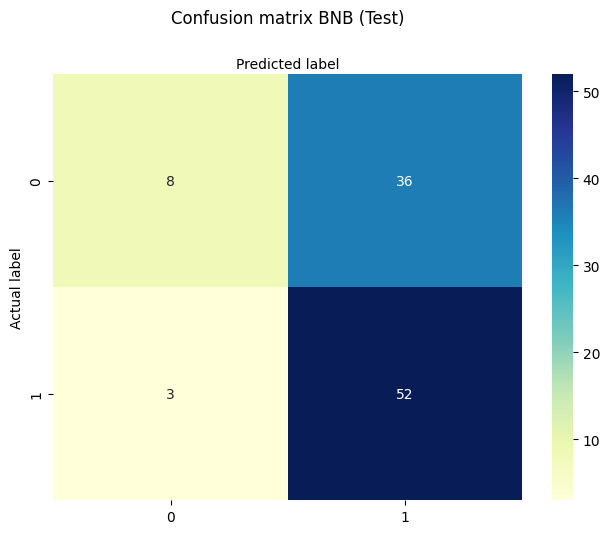

In [327]:
cnf_matrix = metrics.confusion_matrix(y_t, y_t_pred_bnb)
cnf_matrix

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix BNB (Test)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')